In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [2]:
try:
  # Use the %tensorflow_version magic if in colab.
  %tensorflow_version 2.x
except Exception:
  pass

TensorFlow 2.x selected.


In [0]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

keras = tf.keras

In [0]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)
    
def trend(time, slope=0):
    return slope * time
  
  
def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

  
def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)
  
  
def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level
  
  
def window_dataset(series, window_size, batch_size=32,
                   shuffle_buffer=1000):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset
  
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

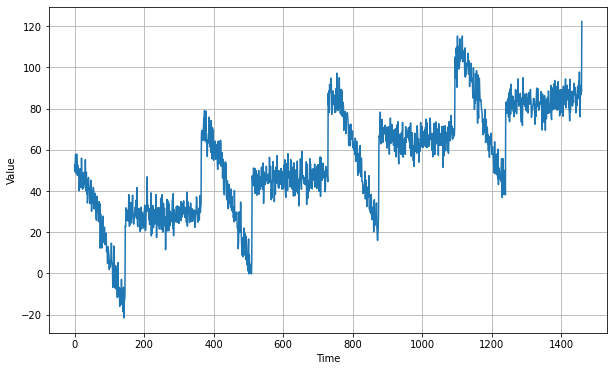

In [5]:
time = np.arange(4 * 365 + 1)

slope = 0.05
baseline = 10
amplitude = 40
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

noise_level = 5
noise = white_noise(time, noise_level, seed=42)

series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

In [0]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [7]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size, batch_size=128)

model = keras.models.Sequential([
  keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  keras.layers.SimpleRNN(100, return_sequences=True),
  keras.layers.SimpleRNN(100),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-7 * 10**(epoch / 20))
optimizer = keras.optimizers.SGD(lr=1e-7, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 3s 397ms/step - loss: 49.6374 - mae: 50.8966
Epoch 2/100
8/8 [==============================] - 1s 63ms/step - loss: 22.8817 - mae: 23.2030
Epoch 3/100
8/8 [==============================] - 1s 64ms/step - loss: 19.4102 - mae: 19.5125
Epoch 4/100
8/8 [==============================] - 1s 64ms/step - loss: 16.8363 - mae: 17.3120
Epoch 5/100
8/8 [==============================] - 1s 73ms/step - loss: 15.6861 - mae: 16.1971
Epoch 6/100
8/8 [==============================] - 1s 86ms/step - loss: 15.1294 - mae: 15.5585
Epoch 7/100
8/8 [==============================] - 1s 63ms/step - loss: 14.5319 - mae: 14.9520
Epoch 8/100
8/8 [==============================] - 1s 64ms/step - loss: 14.0056 - mae: 14.6318
Epoch 9/100
8/8 [==============================] - 1s 68ms/step - loss: 13.6949 - mae: 14.4190
Epoch 10/100
8/8 [==============================] - 0s 59ms/step - loss: 13.4131 - mae: 14.0410
Epoch 11/100
8/8 [==============================

(1e-07, 0.0001, 0.0, 30.0)

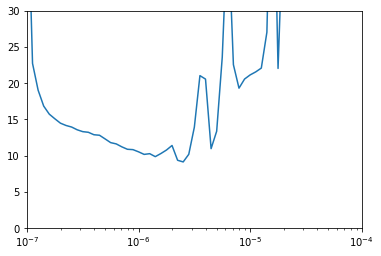

In [8]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-7, 1e-4, 0, 30])

In [9]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size, batch_size=128)
valid_set = window_dataset(x_valid, window_size, batch_size=128)

model = keras.models.Sequential([
  keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  keras.layers.SimpleRNN(100, return_sequences=True),
  keras.layers.SimpleRNN(100),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
optimizer = keras.optimizers.SGD(lr=1.5e-6, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
early_stopping = keras.callbacks.EarlyStopping(patience=50)
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint", save_best_only=True)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint])

Epoch 1/500
      8/Unknown - 2s 253ms/step - loss: 59.2326 - mae: 60.3561WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/ops/resource_variable_ops.py:1786: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: my_checkpoint/assets
8/8 [==============================] - 5s 618ms/step - loss: 59.3019 - mae: 60.3561 - val_loss: 42.0143 - val_mae: 42.3810
Epoch 2/500
8/8 [==============================] - 3s 412ms/step - loss: 36.5803 - mae: 37.3106 - val_loss: 11.4775 - val_mae: 11.7886
Epoch 3/500
8/8 [==============================] - 1s 101ms/step - loss: 23.6567 - mae: 24.0714 - val_loss: 12.7571 - val_mae: 13.0818
Epoch 4/500
8/8 [==============================] - 1s 77ms/step - loss: 16.7817 - mae: 17.6511 - val_loss: 21.4765 

In [0]:
model = keras.models.load_model("my_checkpoint")

In [0]:
rnn_forecast = model_forecast(
    model,
    series[split_time - window_size:-1],
    window_size)[:, 0]

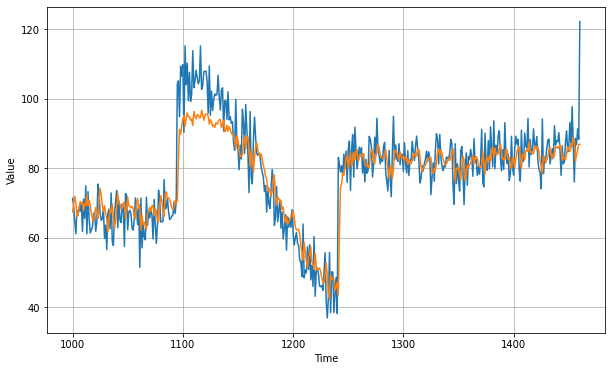

In [12]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)


In [13]:
keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

5.414163

In [0]:
def seq2seq_window_dataset(series, window_size, batch_size=32,
                           shuffle_buffer=1000):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [15]:
for X_batch, Y_batch in seq2seq_window_dataset(tf.range(10), 3,
                                               batch_size=1):
    print("X:", X_batch.numpy())
    print("Y:", Y_batch.numpy())

X: [[[1]
  [2]
  [3]]]
Y: [[[2]
  [3]
  [4]]]
X: [[[3]
  [4]
  [5]]]
Y: [[[4]
  [5]
  [6]]]
X: [[[5]
  [6]
  [7]]]
Y: [[[6]
  [7]
  [8]]]
X: [[[4]
  [5]
  [6]]]
Y: [[[5]
  [6]
  [7]]]
X: [[[6]
  [7]
  [8]]]
Y: [[[7]
  [8]
  [9]]]
X: [[[2]
  [3]
  [4]]]
Y: [[[3]
  [4]
  [5]]]
X: [[[0]
  [1]
  [2]]]
Y: [[[1]
  [2]
  [3]]]


In [16]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)

model = keras.models.Sequential([
  keras.layers.SimpleRNN(100, return_sequences=True,
                         input_shape=[None, 1]),
  keras.layers.SimpleRNN(100, return_sequences=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200)
])
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-7 * 10**(epoch / 30))
optimizer = keras.optimizers.SGD(lr=1e-7, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 2s 226ms/step - loss: 51.8012 - mae: 53.0833
Epoch 2/100
8/8 [==============================] - 1s 68ms/step - loss: 25.6187 - mae: 25.9613
Epoch 3/100
8/8 [==============================] - 1s 73ms/step - loss: 23.2629 - mae: 23.7153
Epoch 4/100
8/8 [==============================] - 1s 66ms/step - loss: 20.7639 - mae: 21.3966
Epoch 5/100
8/8 [==============================] - 1s 68ms/step - loss: 19.3458 - mae: 19.9318
Epoch 6/100
8/8 [==============================] - 1s 66ms/step - loss: 18.7027 - mae: 19.1986
Epoch 7/100
8/8 [==============================] - 1s 64ms/step - loss: 18.1732 - mae: 18.6635
Epoch 8/100
8/8 [==============================] - 1s 66ms/step - loss: 17.6910 - mae: 18.2660
Epoch 9/100
8/8 [==============================] - 1s 76ms/step - loss: 17.3617 - mae: 17.9216
Epoch 10/100
8/8 [==============================] - 1s 84ms/step - loss: 16.9487 - mae: 17.5786
Epoch 11/100
8/8 [==============================

(1e-07, 0.0001, 0.0, 30.0)

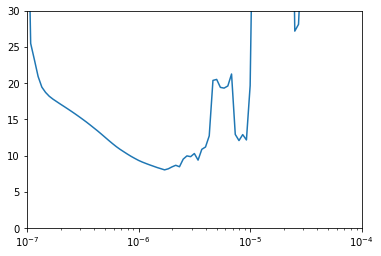

In [17]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-7, 1e-4, 0, 30])

In [18]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)
valid_set = seq2seq_window_dataset(x_valid, window_size,
                                   batch_size=128)

model = keras.models.Sequential([
  keras.layers.SimpleRNN(100, return_sequences=True,
                         input_shape=[None, 1]),
  keras.layers.SimpleRNN(100, return_sequences=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
optimizer = keras.optimizers.SGD(lr=1e-6, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
early_stopping = keras.callbacks.EarlyStopping(patience=10)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping])

Epoch 1/500
8/8 [==============================] - 3s 318ms/step - loss: 55.8513 - mae: 56.2826 - val_loss: 17.6785 - val_mae: 18.0197
Epoch 2/500
8/8 [==============================] - 1s 83ms/step - loss: 33.9155 - mae: 35.1114 - val_loss: 17.4471 - val_mae: 18.0774
Epoch 3/500
8/8 [==============================] - 1s 88ms/step - loss: 28.3637 - mae: 28.6514 - val_loss: 35.8525 - val_mae: 36.0964
Epoch 4/500
8/8 [==============================] - 1s 84ms/step - loss: 21.0046 - mae: 21.6919 - val_loss: 27.8289 - val_mae: 28.4824
Epoch 5/500
8/8 [==============================] - 1s 110ms/step - loss: 17.9119 - mae: 18.5032 - val_loss: 17.8702 - val_mae: 18.4260
Epoch 6/500
8/8 [==============================] - 1s 83ms/step - loss: 15.3045 - mae: 15.8192 - val_loss: 10.6281 - val_mae: 11.1624
Epoch 7/500
8/8 [==============================] - 1s 84ms/step - loss: 13.8782 - mae: 14.3735 - val_loss: 8.7739 - val_mae: 9.2796
Epoch 8/500
8/8 [==============================] - 1s 100ms/st

In [0]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

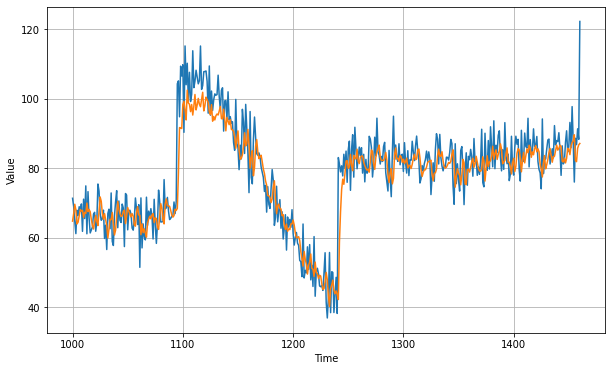

In [20]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [21]:
keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

5.1336265